Step 1. Loading and cleaning data
Data is a set of tweets related to Covid-19, with assigned labels: Extremely Positive, Positive, Neutral, Negative, Extremely Negative

In [38]:
import pandas as pd
df = pd.read_csv("tweets.csv")
df.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4333,8132,53084,Calgary,18-03-2020,BREAKING NEWS: Alberta inflation rate outpaces...,Neutral
3208,7007,51959,Dublin,18-03-2020,Supermarkets adapt to deal with Consumer habit...,Neutral
596,4395,49347,NaN,16-03-2020,Prediciton: Not that it needs a boost but afte...,Extremely Negative
6788,10587,55539,"New Jersey, USA",19-03-2020,#Coronavirus &amp; #COVID-19 Updates - Consume...,Neutral
8014,11813,56765,"London, England",19-03-2020,So I hope during this time @thameswater @Briti...,Positive
5186,8985,53937,United States,18-03-2020,People be hopping into the PS5 architecture re...,Negative
149,3948,48900,London,16-03-2020,First shops to make this effort could really w...,Extremely Positive
1305,5104,50056,"CT, USA",17-03-2020,I told you how my mom starved her Sim to death...,Negative
1652,5451,50403,Los Angeles,17-03-2020,If only the current grocery store profits were...,Positive
3180,6979,51931,"Knoxville, TN",18-03-2020,Governor Lee says TN has a strong food supply ...,Extremely Negative


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8055 entries, 0 to 8054
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       8055 non-null   int64 
 1   ScreenName     8055 non-null   int64 
 2   Location       6469 non-null   object
 3   TweetAt        8055 non-null   object
 4   OriginalTweet  8055 non-null   object
 5   Sentiment      8054 non-null   object
dtypes: int64(2), object(4)
memory usage: 377.7+ KB


In [40]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#removing duplicated tweets
df.drop_duplicates(subset='OriginalTweet', inplace=True)

In [43]:
#removing special characters, URLs, and user mentions
def clean_tweet(text):
    #removing URLs
    text = re.sub(r'http\S+', '', text)
    #removing user mentions
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    #removing special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['CleanTweet'] = df['OriginalTweet'].apply(clean_tweet)

In [44]:
#lowercasing for uniformity
df['CleanTweet'] = df['CleanTweet'].str.lower()

In [45]:
#removing stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

df['CleanTweet'] = df['CleanTweet'].apply(remove_stopwords)
df.drop('OriginalTweet', axis=1, inplace=True)

In [46]:
df.head()

,UserName,ScreenName,Location,TweetAt,Sentiment,CleanTweet
0,3799,48751,London,16-03-2020,Neutral,gahan
1,3800,48752,UK,16-03-2020,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,Positive,food stock one empty please dont panic enough ...
4,3803,48755,NaN,16-03-2020,Extremely Negative,ready go supermarket covid outbreak im paranoi...


In [49]:
#deleting not needed columns
columns_delete = ['UserName', 'ScreenName', 'Location', 'TweetAt']
df.drop(columns_delete, axis=1, inplace=True)

In [50]:
df.head()

,Sentiment,CleanTweet
0,Neutral,gahan
1,Positive,advice talk neighbours family exchange phone n...
2,Positive,coronavirus australia woolworths give elderly ...
3,Positive,food stock one empty please dont panic enough ...
4,Extremely Negative,ready go supermarket covid outbreak im paranoi...


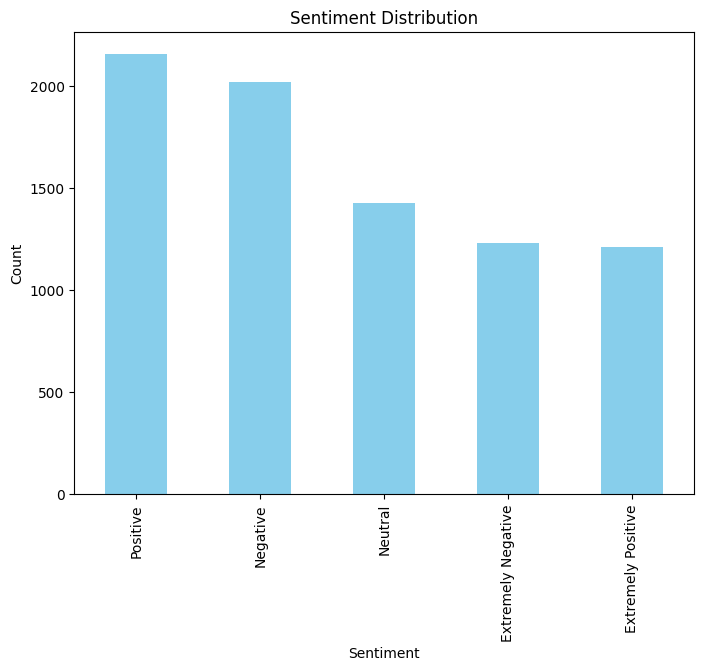

In [55]:
#class distribution
import matplotlib.pyplot as plt
sentiment_distribution = df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


Step 2. Building a CNN model

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['CleanTweet'])
X = tokenizer.texts_to_sequences(df['CleanTweet'])
X = pad_sequences(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment'])
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
embedding_dim = 100  # Adjust as needed
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X.shape[1]))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))




Epoch 1/5
202/202 [==============================] - 5s 22ms/step - loss: 1.4764 - accuracy: 0.3324 - val_loss: 1.2410 - val_accuracy: 0.4618
Epoch 2/5
202/202 [==============================] - 4s 20ms/step - loss: 0.9030 - accuracy: 0.6522 - val_loss: 1.1305 - val_accuracy: 0.5313
Epoch 3/5
202/202 [==============================] - 4s 20ms/step - loss: 0.3743 - accuracy: 0.8790 - val_loss: 1.4566 - val_accuracy: 0.5251
Epoch 4/5
202/202 [==============================] - 4s 20ms/step - loss: 0.1017 - accuracy: 0.9777 - val_loss: 1.7422 - val_accuracy: 0.5320
Epoch 5/5
202/202 [==============================] - 4s 20ms/step - loss: 0.0288 - accuracy: 0.9957 - val_loss: 1.9699 - val_accuracy: 0.5196


In [53]:
# Function to predict sentiment for a single sentence
def predict_sentiment(sentence):
    # Preprocess the input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=X.shape[1])

    # Make predictions
    prediction = model.predict(padded_sequence)

    # Convert prediction to sentiment class
    predicted_class = label_encoder.inverse_transform([prediction.argmax()])[0]

    return predicted_class

In [54]:
# Example usage
test_sentence = "I love this product!"
result = predict_sentiment(test_sentence)
print(f"The sentiment of the sentence '{test_sentence}' is: {result}")

1/1 [==============================] - 0s 150ms/step
The sentiment of the sentence 'I love this product!' is: Extremely Positive
